In [11]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.interpolate import griddata
from pathlib import Path
from frozendict import frozendict
import re
from ast import literal_eval
from collections import Counter, defaultdict
from cycler import cycler
import pandas as pd

colors = plt.cm.gray(np.linspace(0.3,0.9,5))

In [12]:
# keep some parameters fixed in the plot:
fixed_parameters = {"removeuc": True, "maxn": 1}

results = {}

for file in Path("output/").iterdir():
    if file.suffix == ".swp":
        continue
    run_id = file.name.split("_")[1:]
    try:
        params = frozendict({param.split("-")[0]: literal_eval(param.split("-")[1]) for param in run_id})
    except:
        # catch wrong files
        print(run_id)
    
    skip = False
    for param, value in fixed_parameters.items():
        if param not in params or params[param] != value:
            skip = True
    if skip:
        continue
    
    text = file.read_text()
    try:
        res_line = [line for line in text.split("\n") if "avg / total" in line][0]
    except:
        continue
    result = float(re.split(" *", res_line)[-2])
    
    results[params] = result

best_config = max(results, key=results.get)

def generate_runid(config):
    order = ("segment", "C", "removeuc", "minn", "maxn") + (("numfeatures", ) if "numfeatures" in config else tuple())
    ordered_params = ["%s-%s"%(param, str(config[param]) if type(config[param]) != float else "%.10f"%config[param]) for param in order]
    runid = "_".join(ordered_params)
    
    return runid

print(results[best_config])

print("country_%s" % generate_runid(best_config))

['Store']
0.868
country_segment-1000_C-10000.0000000000_removeuc-True_minn-1_maxn-1_numfeatures-1000


In [13]:
xs, ys, zs = [], [], []

for params, result in results.items():
    x = params["segment"]
    y = params["C"]
    xs.append(x)
    ys.append(y)
    zs.append(result)

# Parameter Study
The 3D-plot below shows the classification quality (F1-score) relative to the segment size and the cost parameter $C$ of the SVM.
In the 2D-plot, only the relation between segment size and F1-score is shown.

<IPython.core.display.Javascript object>


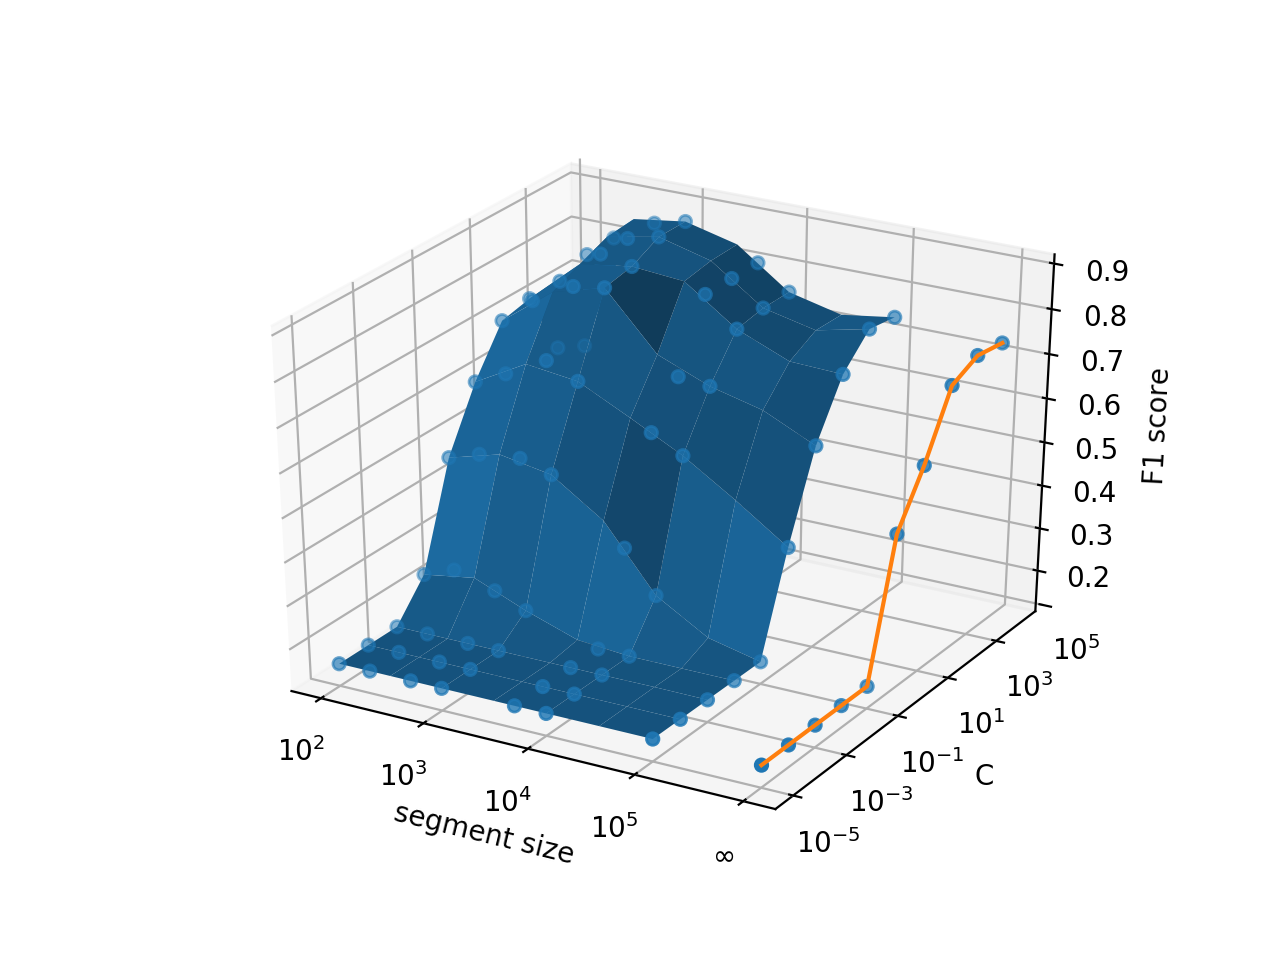

Text(0.5,0,'F1 score')

In [17]:
def log(x):
    """
    This is just for the visualisation below:
    Using the full length of novels is represented by a
    segment size of zero and should be plotted with some
    distance to the other settings.
    """
    return 6 if not x else np.log10(x)

_xs = np.array(list(map(log,xs)))
_ys = np.array(list(map(log,ys)))
_zs = np.array(list(zs))


def plot_surface(_xs, _ys, _zs):
    xyz = {'x': _xs, 'y': _ys, 'z': _zs}

    # put the data into a pandas DataFrame
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 

    # re-create the 2D-arrays
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='cubic')
    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, linewidth=0, antialiased=True)


def filter_infty(_xs, _ys, _zs):
    """
    Filter settings with no segmentation
    """
    return zip(*filter(lambda x: x[0] != 6, zip(_xs, _ys, _zs)))

def get_infty(_xs, _ys, _zs):
    """
    Select only settings with no segmentation
    """
    return zip(*filter(lambda x: x[0] == 6, zip(_xs, _ys, _zs)))
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data = zip(_xs, _ys, _zs)
_xs, _ys, _zs = zip(*list(sorted(data, key = lambda _x: (_x[1], _x[0], _x[2]))))

plot_surface(*filter_infty(_xs, _ys, _zs))
ax.scatter(xs=_xs, ys=_ys, zs=_zs)
_xs, _ys, _zs = get_infty(_xs, _ys, _zs)
ax.plot(_xs, _ys, _zs)

ax.set_xlabel("segment size")
ax.set_ylabel("C")
xrange = range(2,7)
ax.set_xticks(xrange)
ax.set_xticklabels(["$10^{%i}$" % i for i in xrange[:-1]] + ["$\infty$"])

yrange = range(-5,6,2)
ax.set_yticks(yrange)
ax.set_yticklabels(["$10^{%i}$" % i for i in yrange])
ax.set_zlabel("F1 score")

<IPython.core.display.Javascript object>


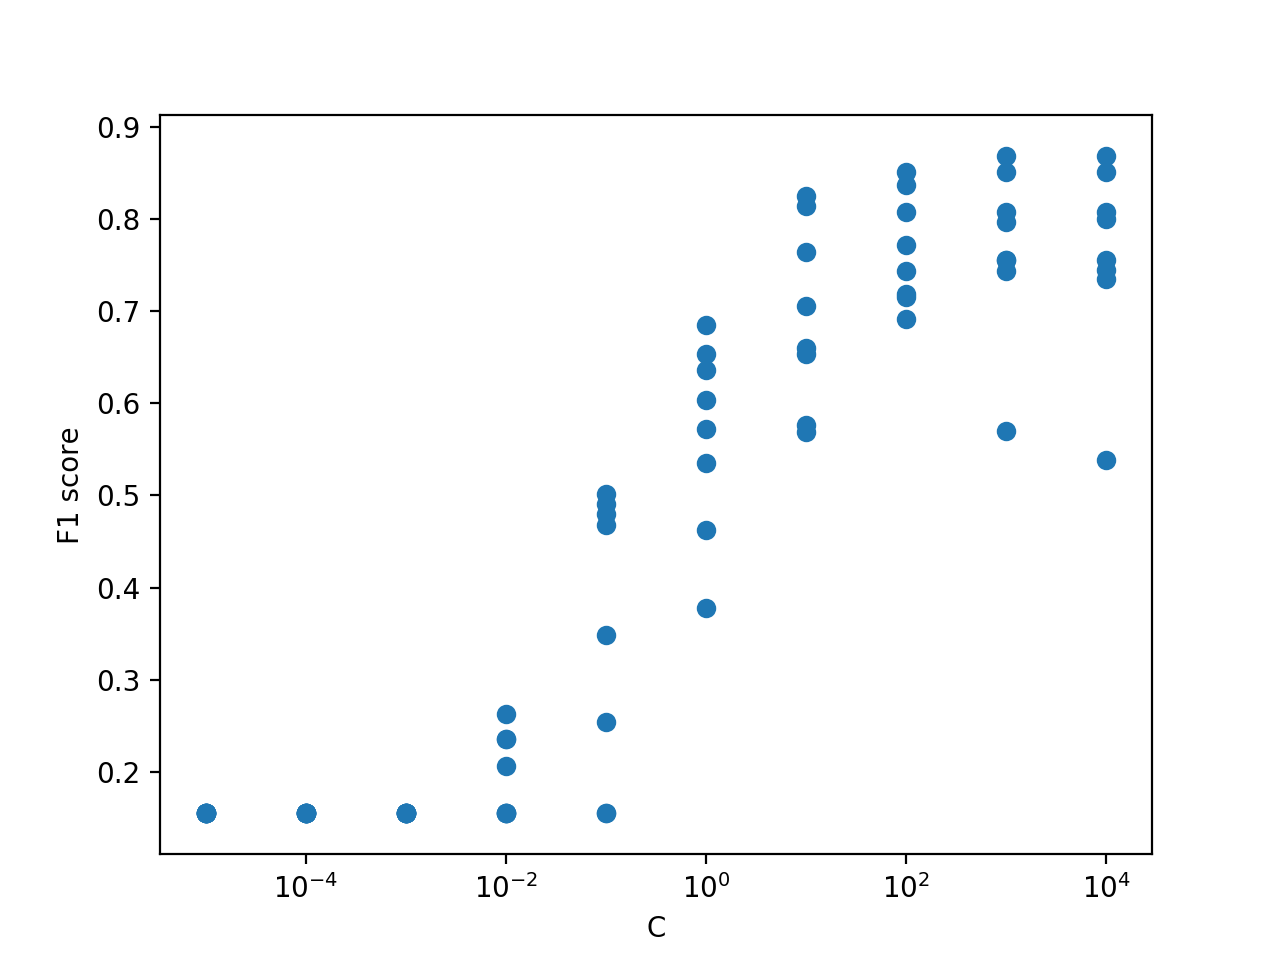

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel("C")
ax.set_ylabel("F1 score")
ax.set_xscale("log")

plt.scatter(ys, zs)

plt.show()

# Some Corpus Statistics

## Country Distribution

<IPython.core.display.Javascript object>


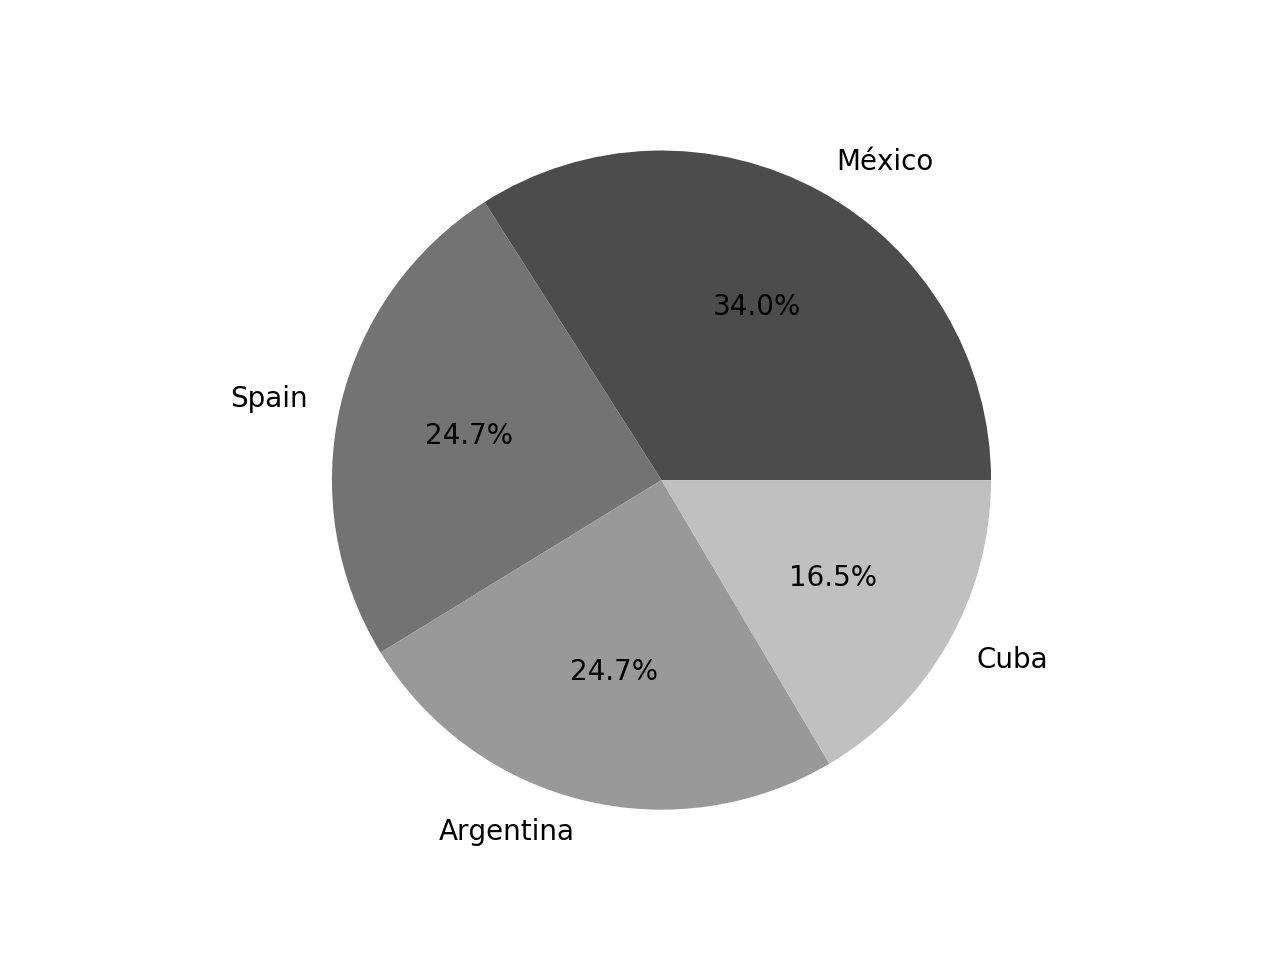

In [15]:
def extract_file_name(filename):
    p = re.compile("(.*?)_([^._]*)(_([^.]*))?.txt")

    m = p.match(filename)
    if m:
        fid = m.group(1)
        label = m.group(2)
        proto = True if m.group(4) is not None else False
        return fid, label, proto
    else:
        return None

fid_to_label = {}
    
for file in Path("corpus_txt/").iterdir():
    fid, label, proto = extract_file_name(file.name)
    fid_to_label[fid] = label

most_common = Counter(fid_to_label.values()).most_common()
labels, sizes = zip(*most_common)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
ax.axis("equal")
plt.show()

## Subgenre Distribution by Country

<IPython.core.display.Javascript object>


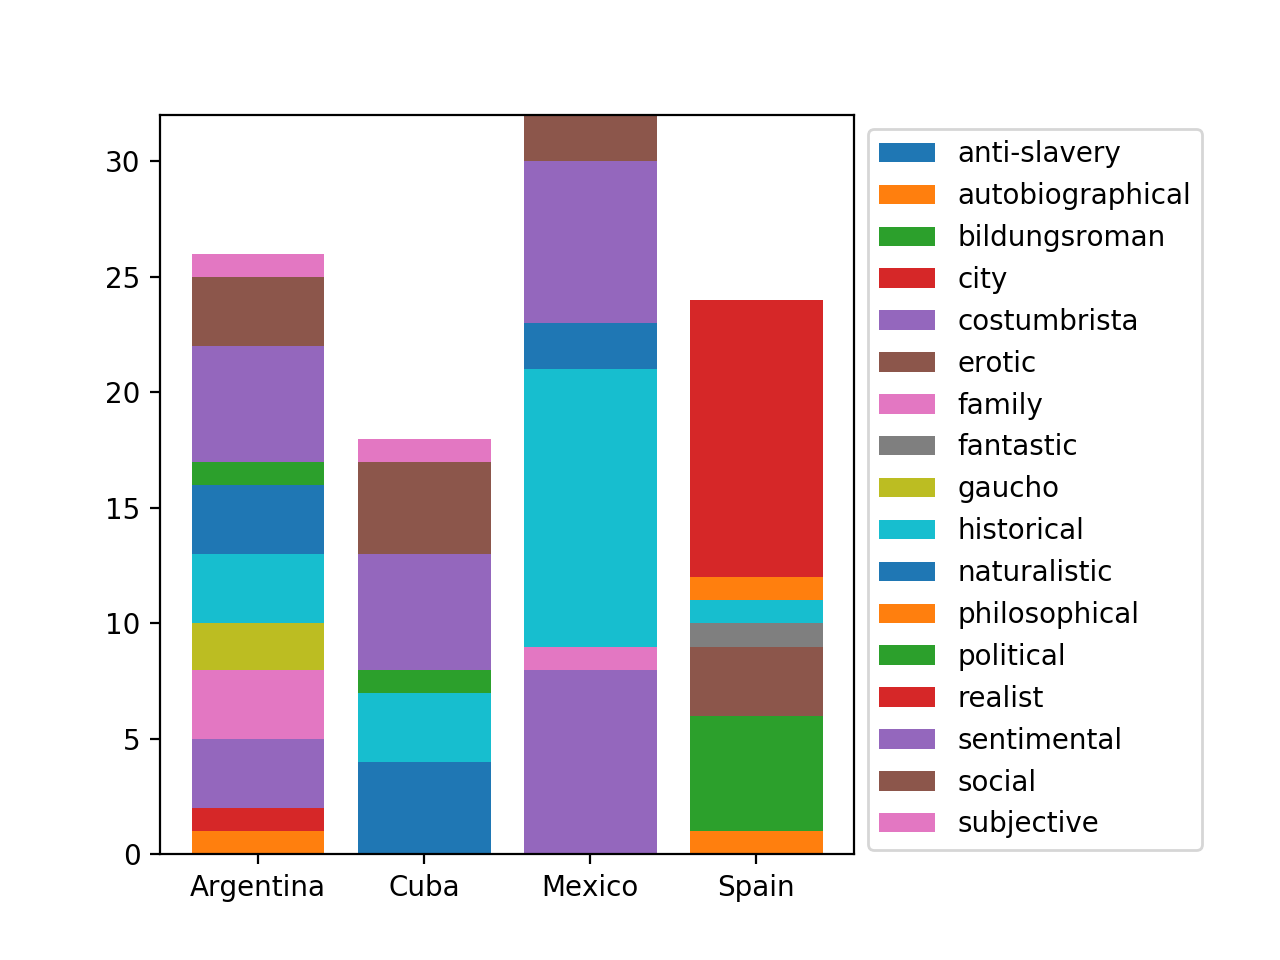

In [16]:
metadata_path = "metadata_opt-obl.csv"
metadata = pd.read_csv(metadata_path, index_col=0)

metadata["author-country"][metadata["author-country"] == "México"] = "Mexico"

fig = plt.figure()
ax = plt.subplot(111)

country_list = sorted(set(metadata["author-country"]))

country_to_int = {country: i for i, country in enumerate(country_list)}

sum = np.zeros(4)


meta_by_genre = metadata.groupby("subgenre")
for genre, novels in meta_by_genre.groups.items():
    countries, novels = zip(*Counter(metadata["author-country"][novels]).most_common())
    countries = list(countries)
    novels = list(novels)
        
    for country in country_list:
        if country not in countries:
            countries.append(country)
            novels.append(0)
    
    countries = list(map(country_to_int.__getitem__, countries))
    
    countries, novels = list(zip(*sorted(zip(countries, novels))))
        
    ax.bar(countries, novels, bottom=sum)
    
    sum += novels
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
ax.legend(meta_by_genre.groups, bbox_to_anchor=(1,1))
ax.set_xticks(range(4))
ax.set_xticklabels(country_list)
plt.show()

#for noid, novel in metadata.iterrows():
#    print(novel["author-country"])